# AP2 - Pattern Recognition
KNN classification implementation, attributes extraction and k-fold validation to classify a sensory glove dataset.

> Name: Jonas Carvalho Fortes

> Mat: 494513



## Load Dataset

In [29]:
from scipy.io import loadmat
import pandas as pd

input_data = loadmat('data\InputData.mat')
output_data = loadmat('data\OutputData.mat')

df_input_data = pd.DataFrame(input_data['InputData'])
df_output_data = pd.DataFrame(output_data['OutputData'])

print(f'Input data shape: {df_input_data.shape}')
print(f'Output data shape: {df_output_data.shape}')


Input data shape: (1500, 120)
Output data shape: (120, 1)


In [21]:
print('Input data:')
df_input_data

Input data:


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-2568,-1864,2692,-700,180,1516,992,3272,3740,1980,...,8360,14692,13120,17788,12544,11560,16540,10592,10256,9228
1,-2060,-1984,1464,-1364,-60,1112,980,2464,2704,2456,...,9868,15588,16428,20044,13044,10468,15416,10208,10984,9344
2,-2216,-1776,-108,-1900,-504,2456,500,1456,1756,2308,...,12068,17488,16416,20148,13504,10564,15264,10012,11632,9668
3,-2352,-1928,-1812,-2340,-548,2872,-208,1968,1736,1904,...,18920,18604,15400,19412,15472,10572,16504,10068,12308,9152
4,-1436,-3044,-2060,-1752,-560,2544,-676,1884,1656,1508,...,21100,18916,16860,18936,16072,10740,16576,10580,15328,9420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,14204,13736,13792,14168,13520,12708,12232,12696,11816,12968,...,12228,15992,14164,12220,13204,11724,14496,16068,15280,17004
1496,14460,13784,13904,14204,13620,12360,12508,12900,11900,12872,...,12252,15868,14112,11912,13652,11592,14460,15888,15080,16864
1497,14868,13744,14108,14532,13404,12444,12536,12908,11912,12848,...,12312,15728,14284,11800,13608,11640,14288,15668,15476,16740
1498,15176,13620,14180,14460,13320,12372,12348,12820,11864,12812,...,12204,15672,14420,11972,13372,12012,14200,15796,15488,16888


In [22]:
print('Output data:')
df_output_data

Output data:


,0
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
115,1
116,1
117,1
118,1


## Auxiliary Functions

### K-NN and K-folds Implementation

In [216]:
from sklearn.metrics import accuracy_score
import numpy as np

# Função para randomizar a base de dados
def shuffle_data(X, y):
    permutation = np.random.permutation(len(y))
    return X[permutation], y[permutation]

# Calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
    distance = 0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2
    return distance ** 0.5

# Find the k nearest neighbors for a given test instance
def find_neighbors(X_train, y_train, X_test, k):
    distances = []
    for i in range(len(X_train)):
        distance = euclidean_distance(X_train[i], X_test)
        distances.append((distance, y_train[i]))
    distances.sort(key=lambda x: x[0])
    neighbors = [distances[i][1] for i in range(k)]
    return neighbors

# Predict the label for a given test instance using K-NN
def knn(X_train, y_train, X_test, k):
    neighbors = find_neighbors(X_train, y_train, X_test, k)
    counts = {}
    for neighbor in neighbors:
        if neighbor in counts:
            counts[neighbor] += 1
        else:
            counts[neighbor] = 1
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_counts[0][0]

# Função para realizar K-fold cross-validation
def k_fold_cross_validation(X, y, k_folds, k, knn_func):

    # Dividir os dados em K folds
    fold_size = len(y) // k_folds
    folds_X = [X[i*fold_size:(i+1)*fold_size] for i in range(k_folds)]
    folds_y = [y[i*fold_size:(i+1)*fold_size] for i in range(k_folds)]

    # Ajuste para incluir todas as amostras na última dobra (caso o tamanho da amostra não seja divisível por k)
    if len(y) % k_folds != 0:
        folds_X[-1] = np.concatenate(folds_X[-1:] + [X[k_folds * fold_size:]], axis=0)
        folds_y[-1] = np.concatenate(folds_y[-1:] + [y[k_folds * fold_size:]], axis=0)

    accuracies = []

    # Iterar sobre cada fold
    for i in range(k_folds):
        X_test = folds_X[i]
        y_test = folds_y[i]
        X_train = np.concatenate([folds_X[j] for j in range(k_folds) if j != i], axis=0)
        y_train = np.concatenate([folds_y[j] for j in range(k_folds) if j != i], axis=0)
        
        y_pred = [knn_func(X_train, y_train, X_test[j], k) for j in range(len(X_test))]
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Calcular a acurácia média
    mean_accuracy = np.mean(accuracies).round(2)
    return mean_accuracy

### Features Extration

In [221]:
import numpy as np
import scipy.stats as stats
from scipy.fft import fft

def calculate_entropy(signal):
    histogram, bin_edges = np.histogram(signal, bins=10, density=True)
    return stats.entropy(histogram)

def extract_features(signal):
    features = []
    # Estatísticas básicas
    features.append(np.mean(signal))                # 1. Média
    features.append(np.std(signal))                 # 2. Desvio padrão
    features.append(np.max(signal))                 # 3. Máximo
    features.append(np.min(signal))                 # 4. Mínimo
    features.append(np.median(signal))              # 5. Mediana
    features.append(np.percentile(signal, 25))      # 6. Primeiro quartil (25%)
    features.append(np.percentile(signal, 75))      # 7. Terceiro quartil (75%)
    
    # Estatísticas de forma de onda
    features.append(stats.skew(signal))             # 8. Assimetria (skewness)
    features.append(stats.kurtosis(signal))         # 9. Curtose (kurtosis)
    
    # Transformada de Fourier
    fft_vals = np.abs(fft(signal))
    features.append(np.mean(fft_vals))              # 10. Média da Transformada de Fourier (FFT)
    
    # Entropia
    features.append(calculate_entropy(signal))      # 11. Entropia
    
    return np.array(features)

### Scatterplot Function

In [41]:
import matplotlib.pyplot as plt


# Lista com os nomes dos atributos
feature_names = [
    'Média', 'Desvio Padrão', 'Máximo', 'Mínimo', 'Mediana', 
    'Primeiro Quartil', 'Terceiro Quartil', 'Assimetria', 'Curtose', 
    'Média FFT', 'Entropia'
]


# Função para plotar gráficos de dispersão
def plot_scatter(feature1, feature2, features, labels, feature_names):
    plt.scatter(features[:, feature1], features[:, feature2], c=labels, cmap='bwr', alpha=0.7)
    plt.xlabel(feature_names[feature1])
    plt.ylabel(feature_names[feature2])
    plt.title(f'{feature_names[feature1]} vs {feature_names[feature2]}')
    plt.show()

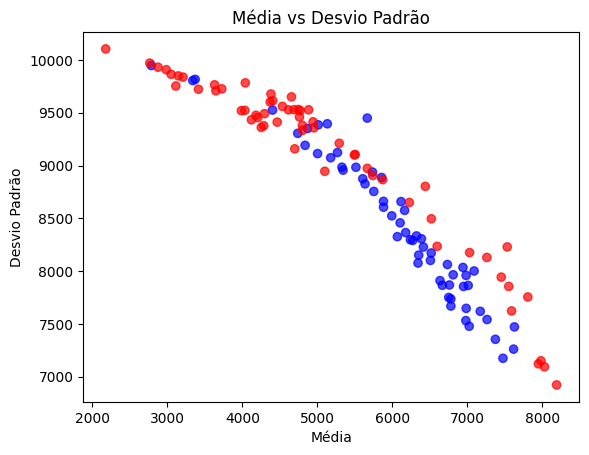

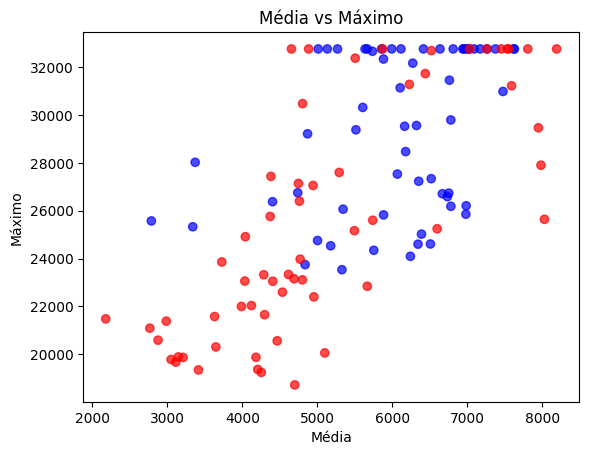

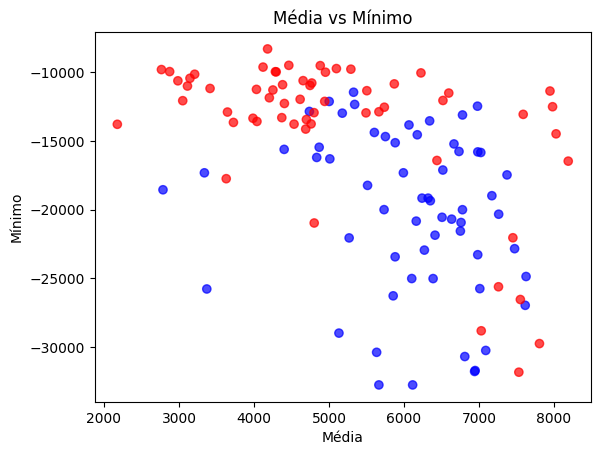

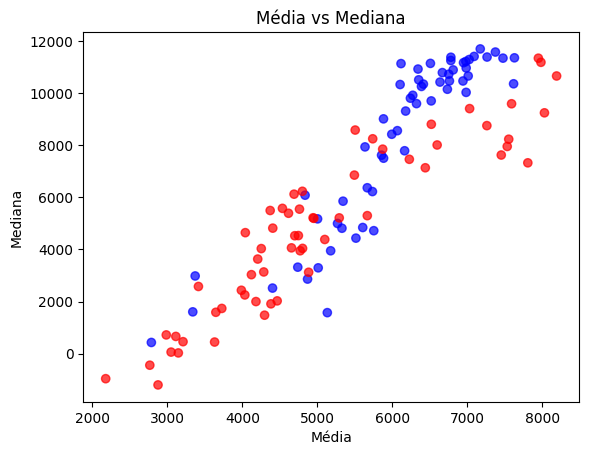

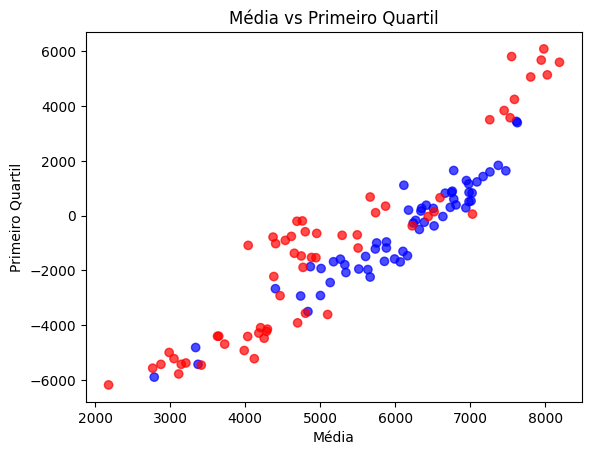

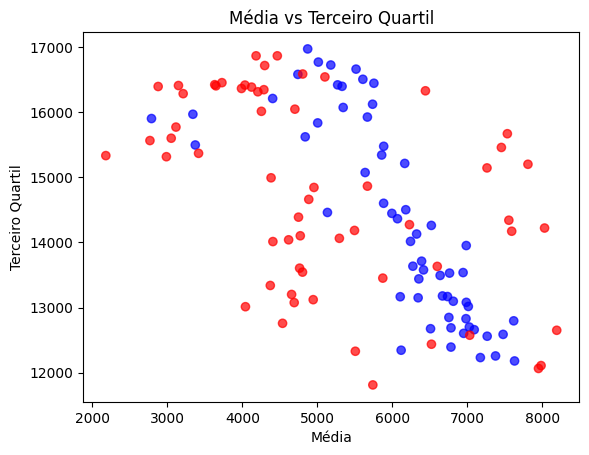

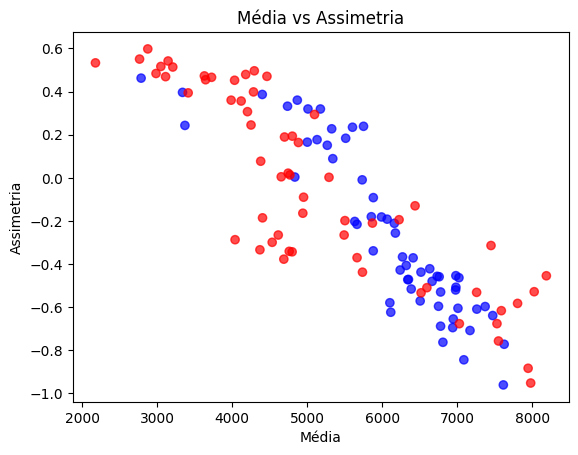

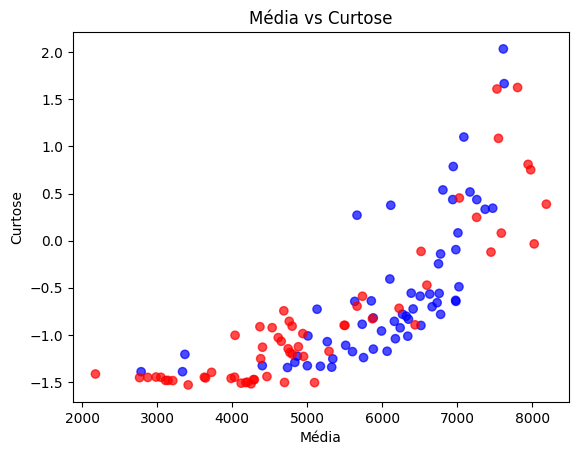

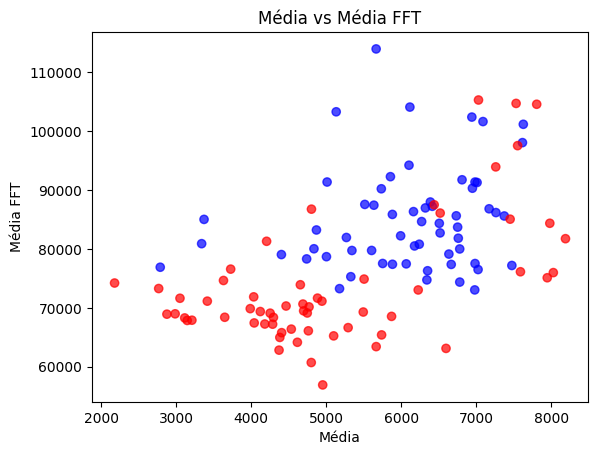

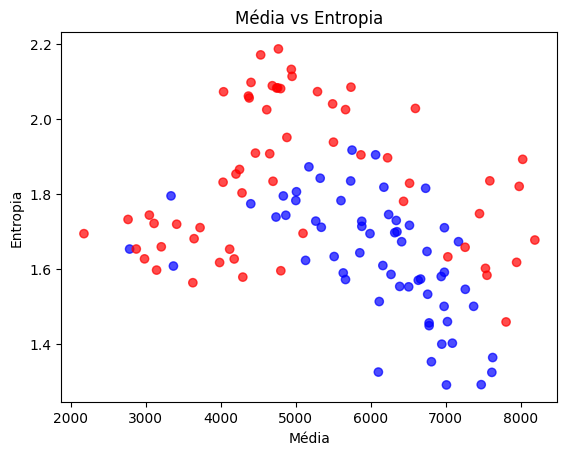

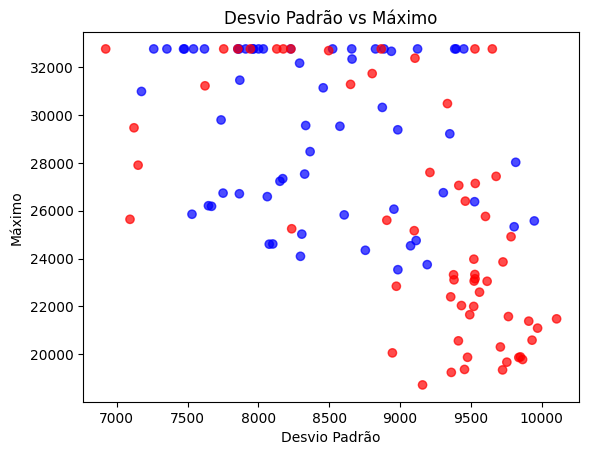

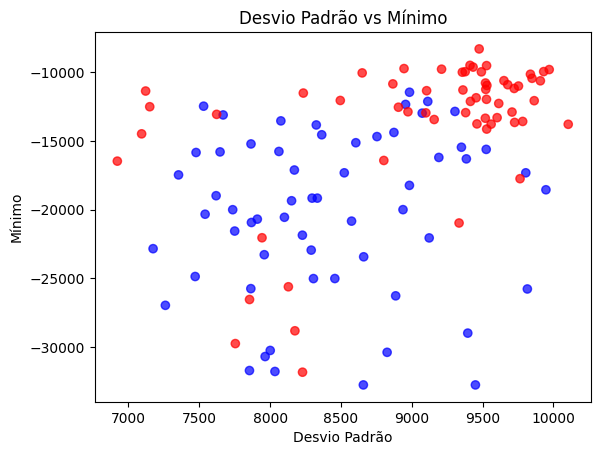

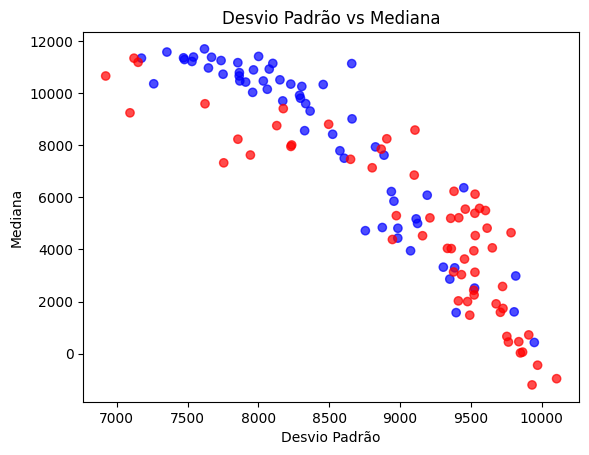

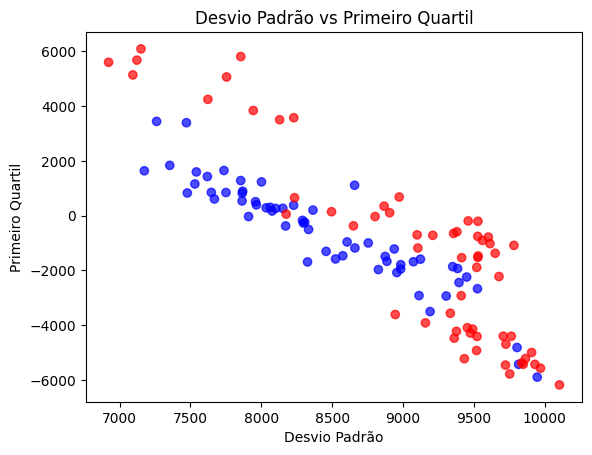

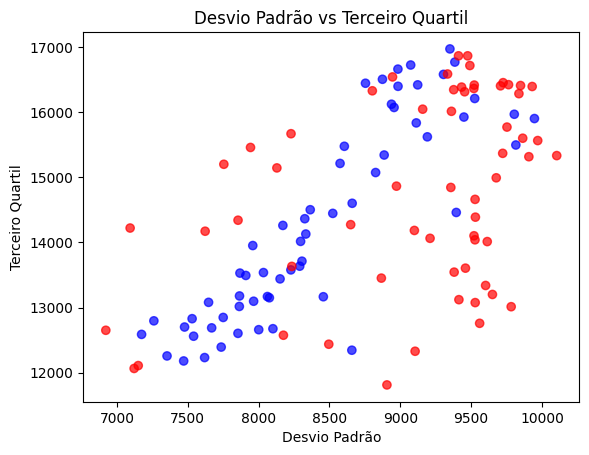

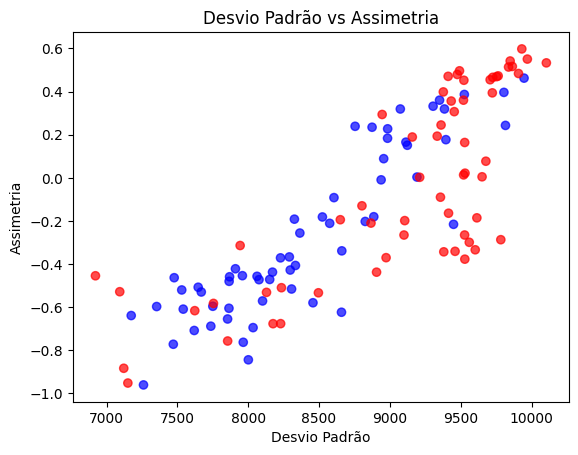

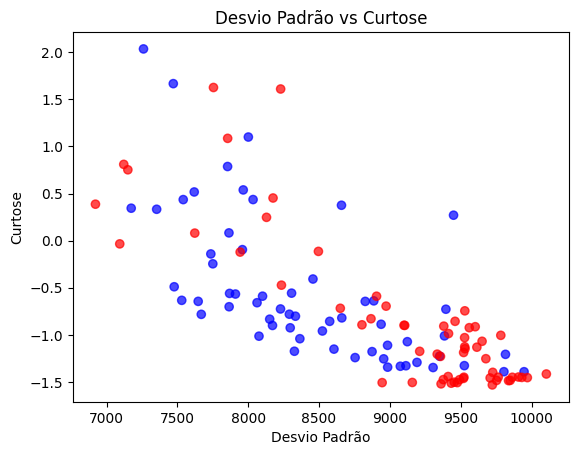

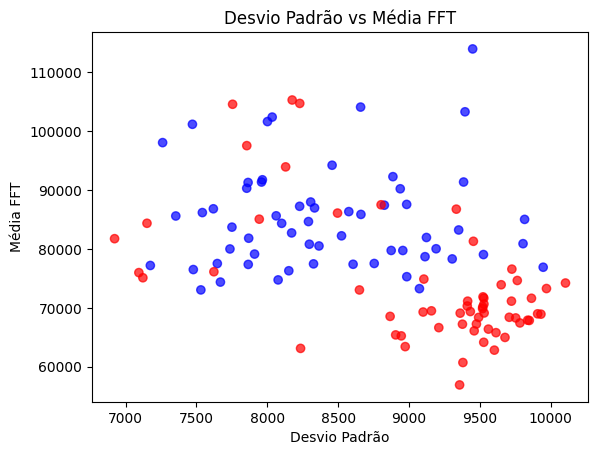

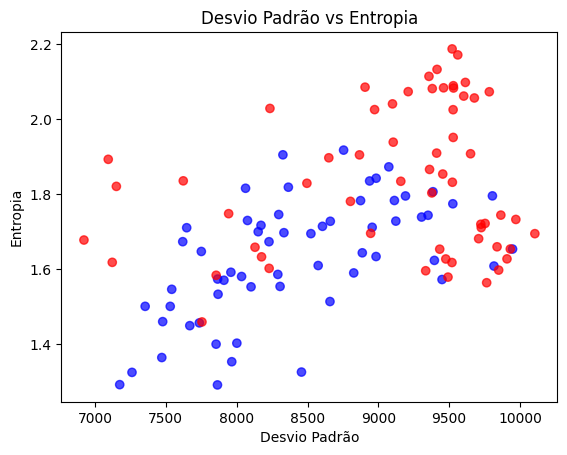

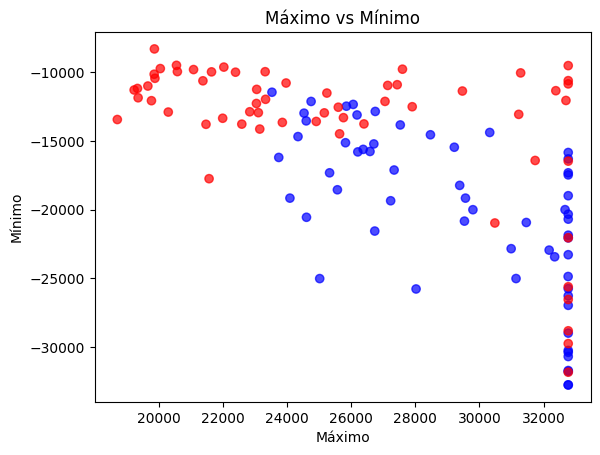

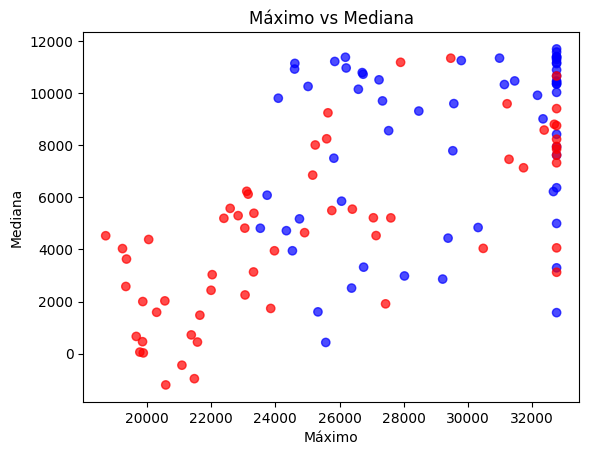

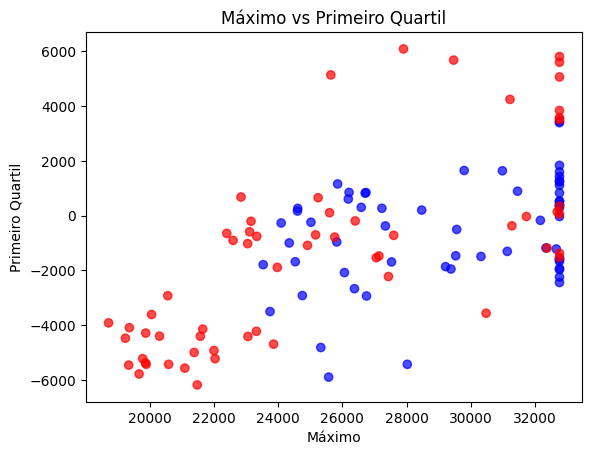

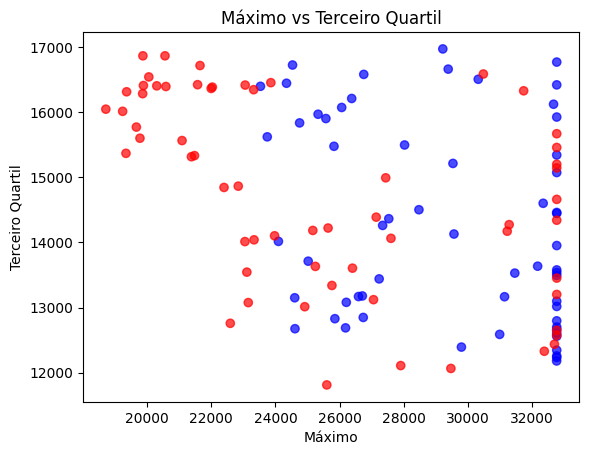

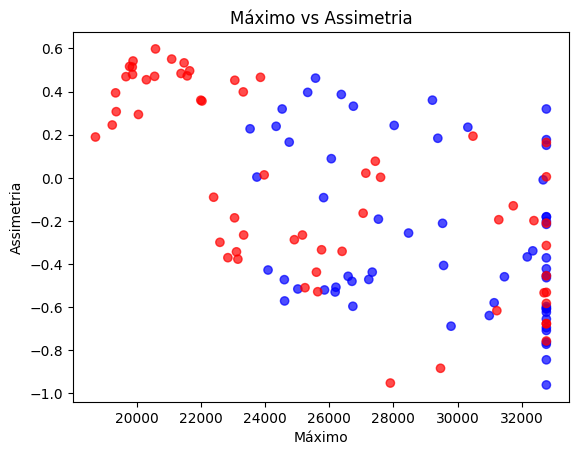

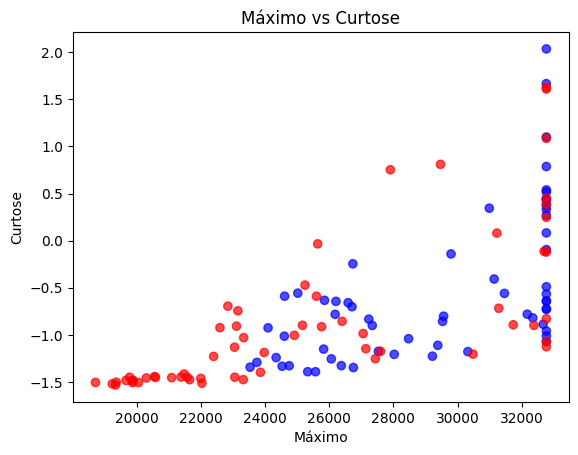

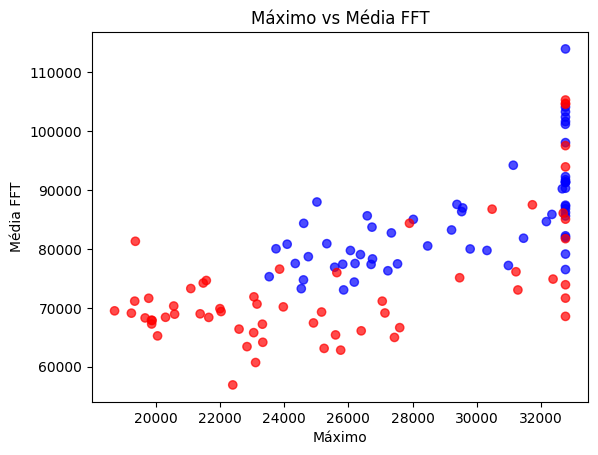

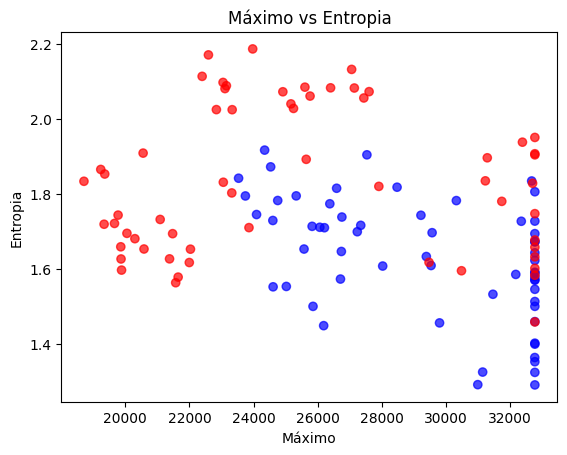

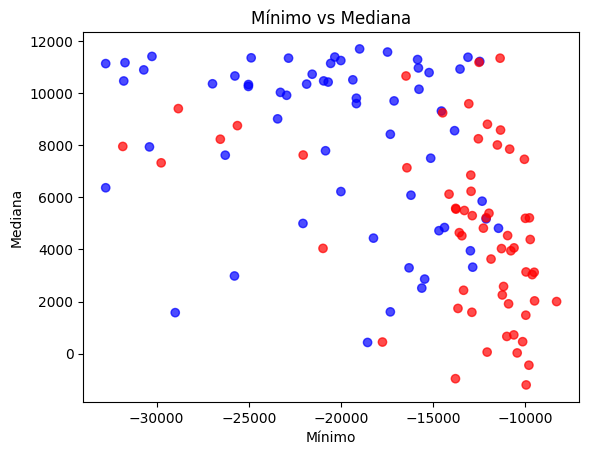

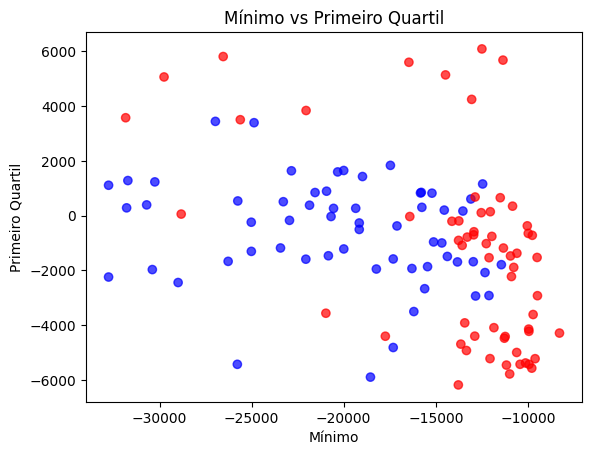

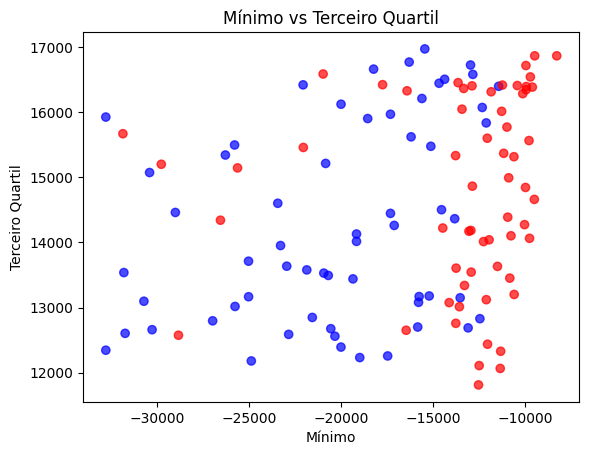

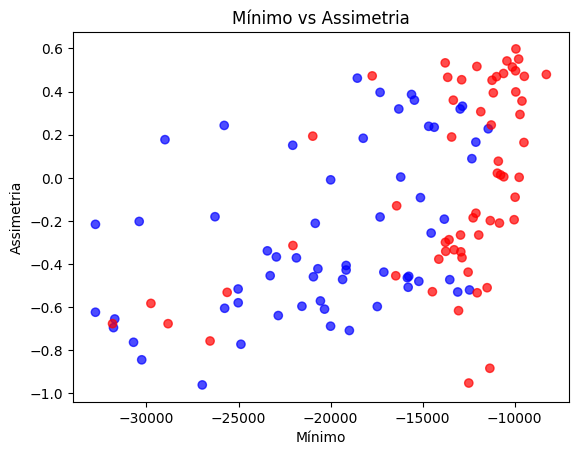

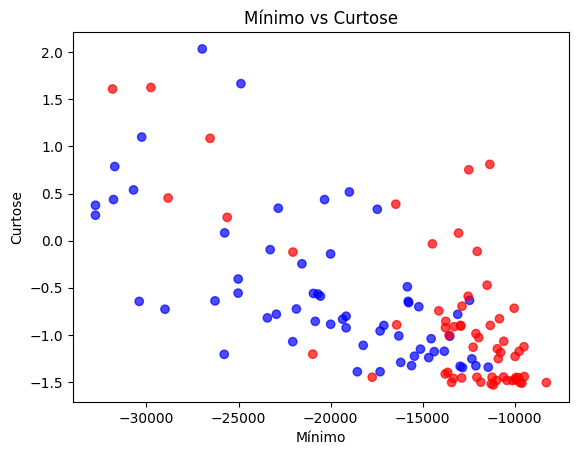

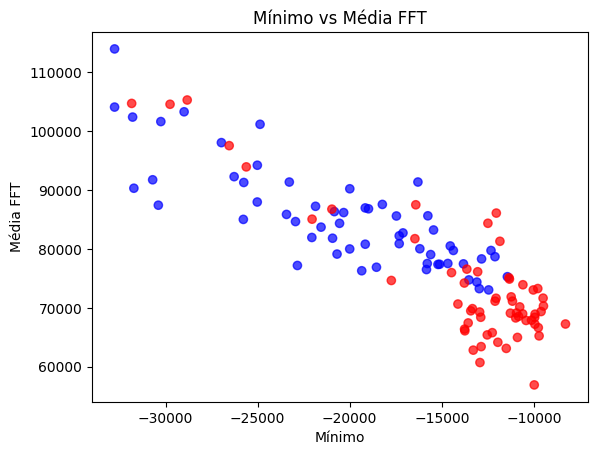

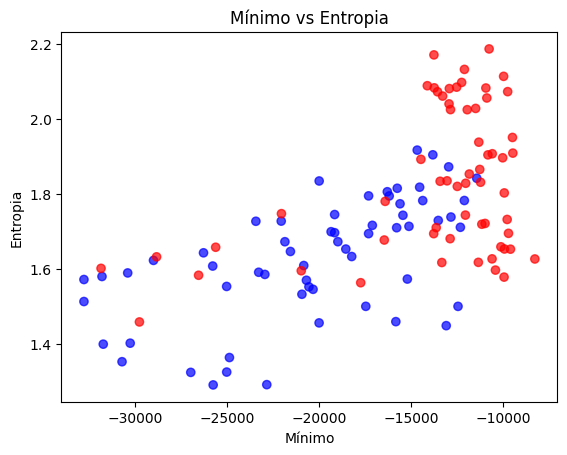

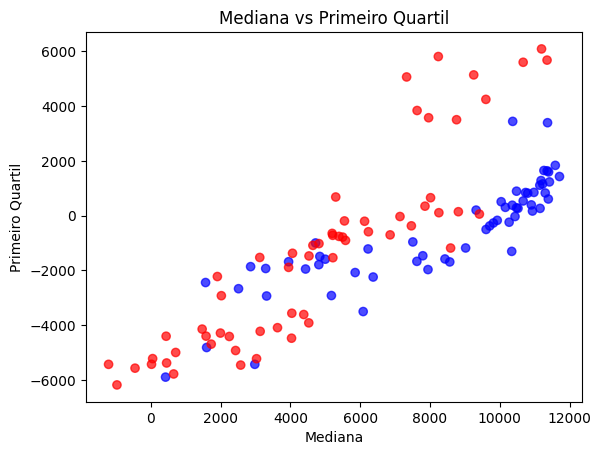

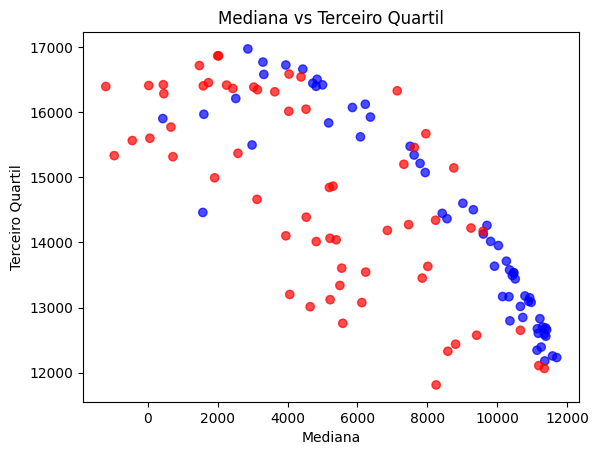

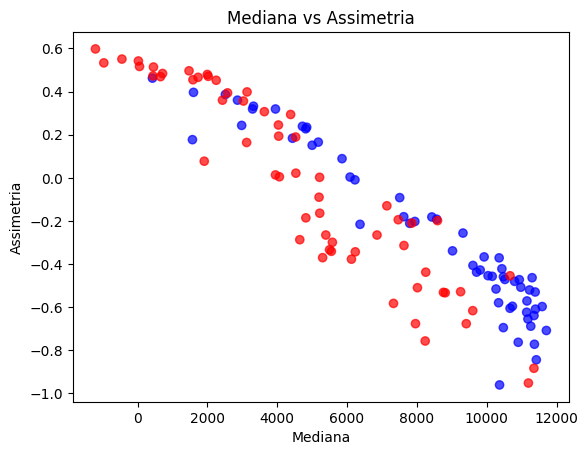

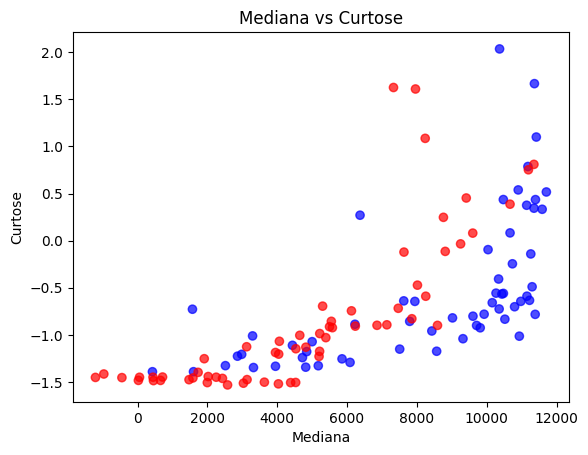

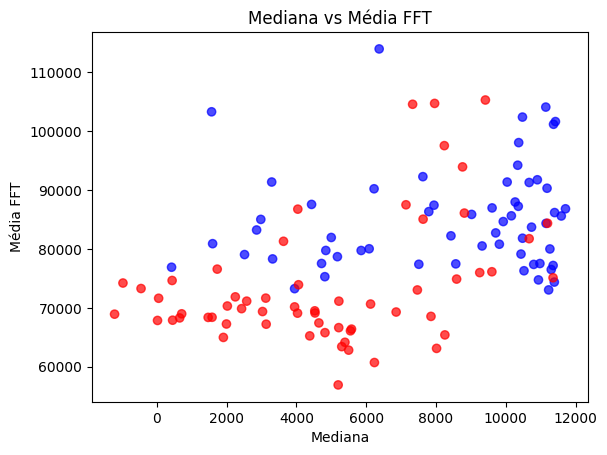

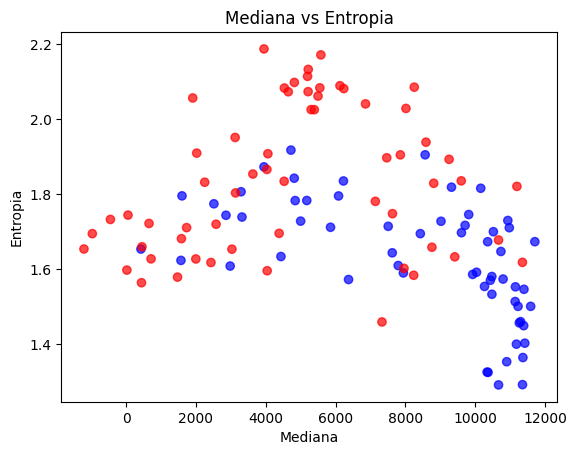

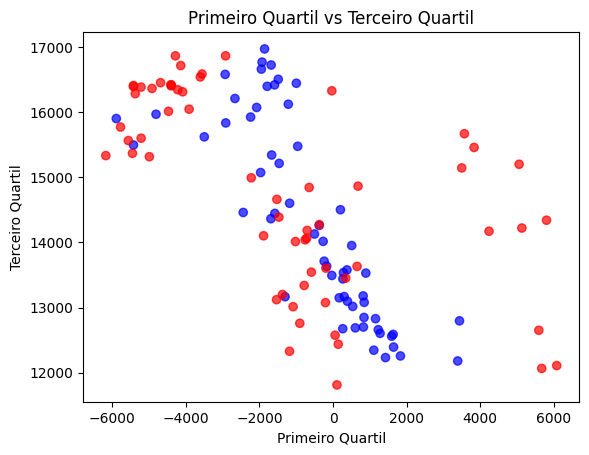

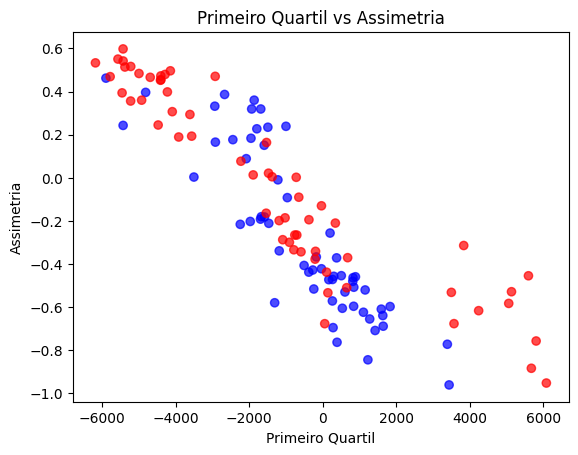

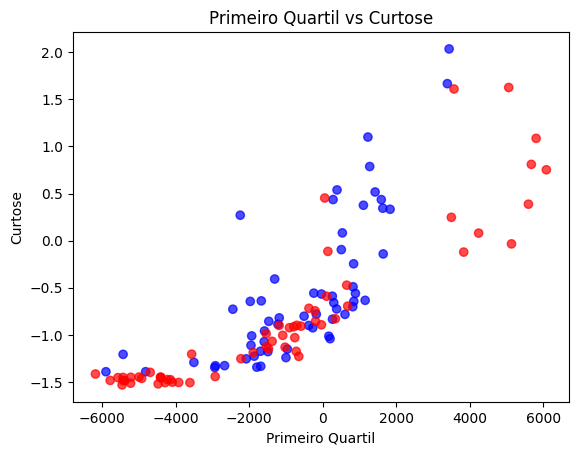

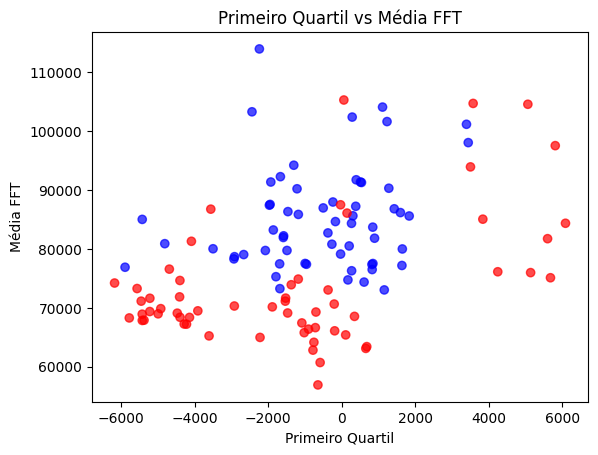

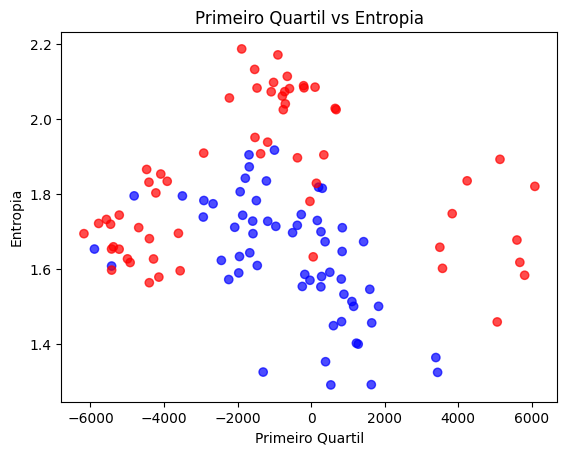

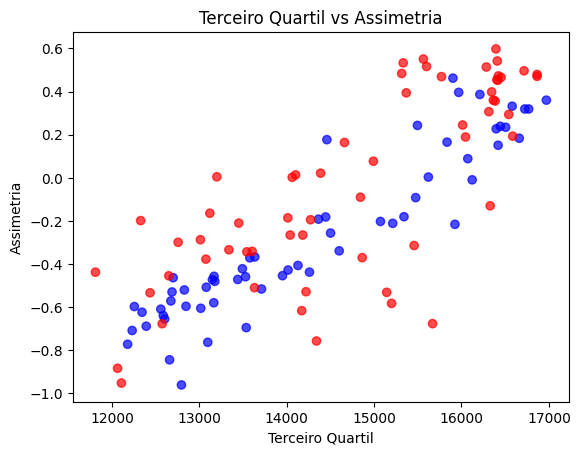

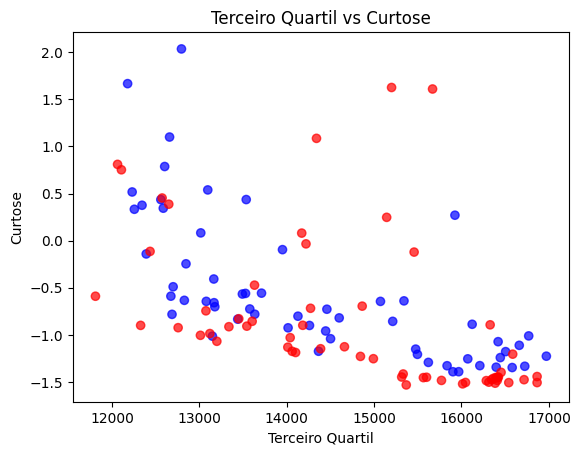

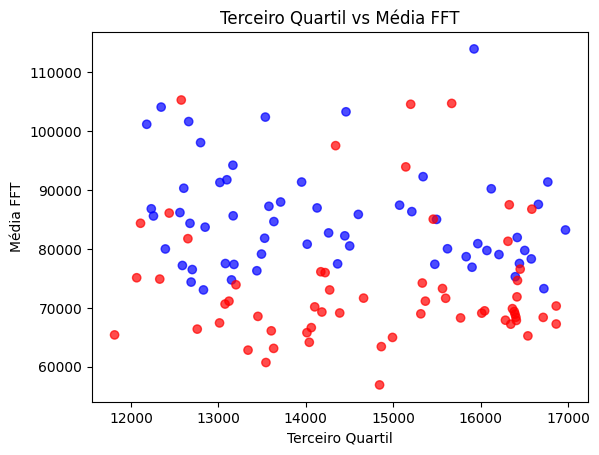

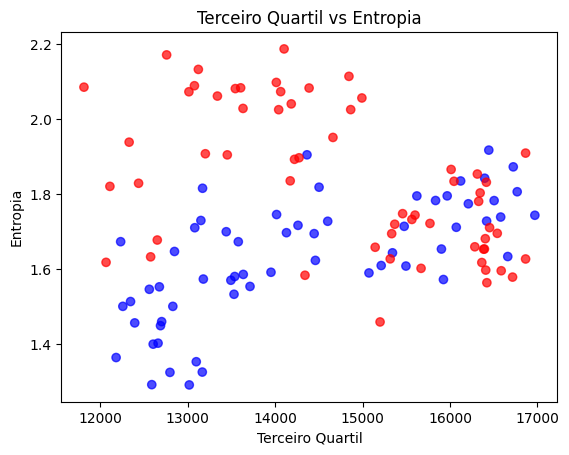

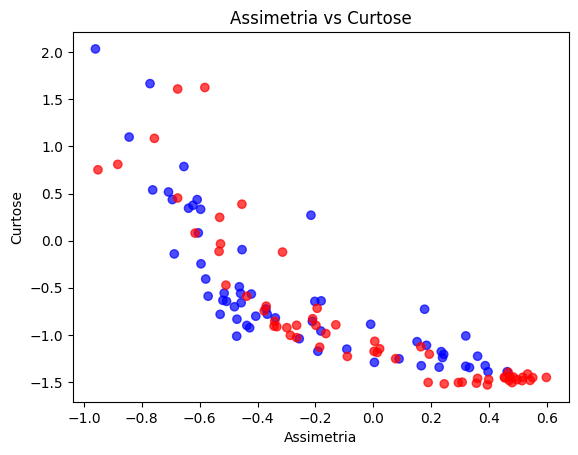

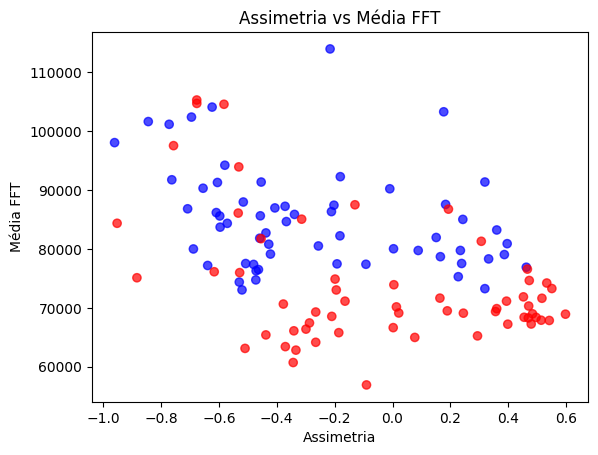

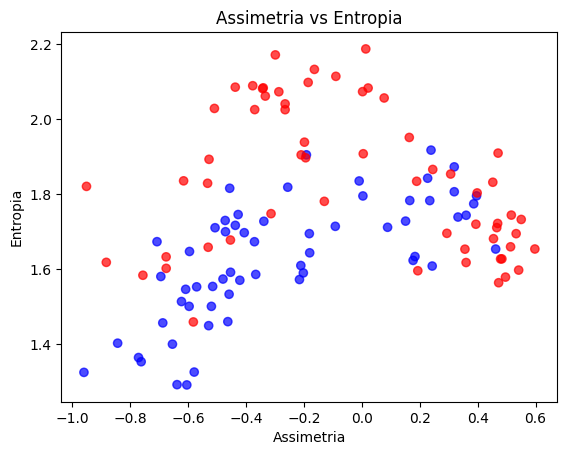

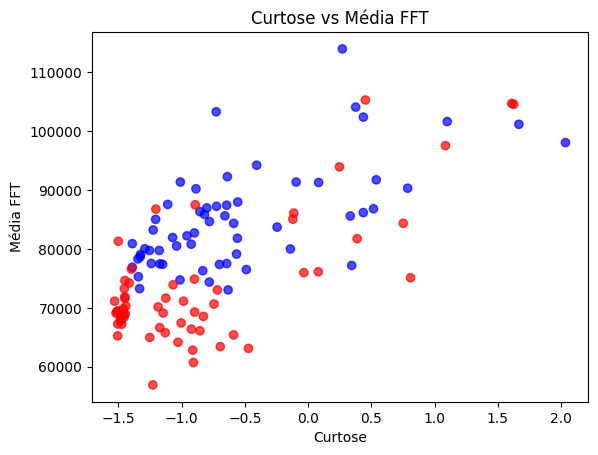

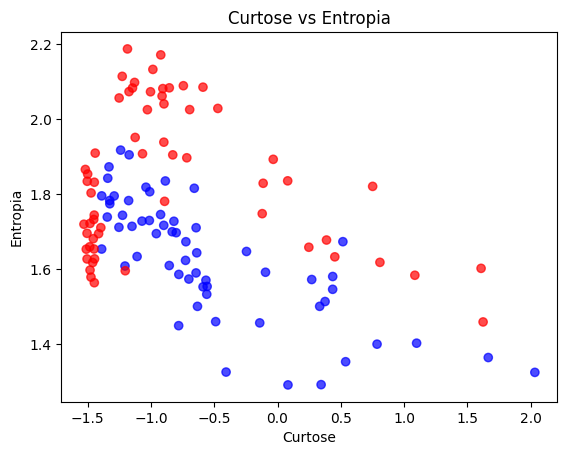

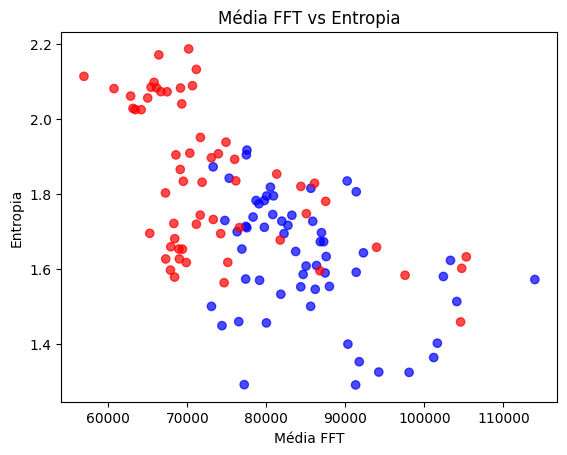

In [80]:
# Plotar gráficos de dispersão para todos os pares de atributos
num_features = all_features.shape[1]
for i in range(num_features):
    for j in range(i + 1, num_features):
        plot_scatter(i, j, all_features, df_output_data, feature_names)

## Train and Prediction

In [228]:
# Extrair características para todas as amostras
all_features = np.array([extract_features(df_input_data.iloc[:, i]) for i in range(df_input_data.shape[1])])


X = all_features
y = df_output_data.values.flatten() 

print(f'all_features shape: {X.shape}')
print(f'Output data shape: {y.shape}')

# Randomizar os dados
X, y = shuffle_data(X, y)

# Definir o número de folds e o valor de k para K-NN
k_folds = 10
k = 4

# Realizar K-fold cross-validation no conjunto de treinamento
mean_accuracy = k_fold_cross_validation(X, y, k_folds, k, knn)
print(f"Acurácia média após {k_folds}-fold cross-validation: {mean_accuracy}")


all_features shape: (120, 11)
Output data shape: (120,)
Acurácia média após 10-fold cross-validation: 0.86
